In [1]:
import os
import random

from keras import utils
from collections import defaultdict
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
DATA_DIR = '/mnt/h/Data/voices/recordings/'
SPEC_DIR_TRAIN = './Data/train/'
SPEC_DIR_TEST = './Data/test/'

In [ ]:
'''
' Create dictionary of all files by speaker
' We want to split by speaker to ensure we have data for all speakers in training and testing datasets.
'''
speaker_files = defaultdict(list)

for file in os.listdir(DATA_DIR):
    parts = file.split('_')
    speaker = parts[1]
    speaker_files[speaker].append(file)

In [ ]:
len(speaker_files['george'])

In [ ]:
import os

base_path = "./Data/"

# Loop through both train and test
for split in ["train", "test"]:
    print(f"\n[{split.upper()}]")
    split_path = os.path.join(base_path, split)
    
    # Loop through label folders (0–9)
    for label in sorted(os.listdir(split_path)):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            num_samples = len(os.listdir(label_path))
            print(f"Label {label}: {num_samples} samples")

In [ ]:
'''
' PLEASE NOTE THAT THIS NOT MY CODE AND WILL FORM PART OF THE API
' THIS WAS ONLY USED FOR EASE OF TESTING AND WILL CHANGE AS MENTIONED ABOVE TO THE API
' URL TO DATASET: https://github.com/Jakobovski/free-spoken-digit-dataset
'''
def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=64, cmap='gray_r'):
    """ Creates a spectrogram of a wav file.

    :param audio_path: path of wav file
    :param save_path:  path of spectrogram to save
    :param spectrogram_dimensions: number of pixels the spectrogram should be. Defaults (64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :param cmap: the color scheme to use for the spectrogram. Defaults to 'gray_r'
    :return:
    """

    sample_rate, samples = wav.read(audio_path)

    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig) # Added for memory efficiency

import scipy

def trim_silence(audio, noise_threshold=450):
    """ Removes the silence at the beginning and end of the passed audio data

    :param audio: numpy array of audio
    :param noise_threshold: the maximum amount of noise that is considered silence
    :return: a trimmed numpy array
    """
    start = None
    end = None

    for idx, point in enumerate(audio):
        if abs(point) > noise_threshold:
            start = idx
            break

    # Reverse the array for trimming the end
    for idx, point in enumerate(audio[::-1]):
        if abs(point) > noise_threshold:
            end = len(audio) - idx
            break

    return audio[start:end]

def trim_silence_file(file_path, noise_threshold=450):
    """Accepts a file path, trims the audio and overwrites the original file with the trimmed version.

    :param file_path: file to trim
    :param noise_threshold: the maximum amount of noise that is considered silence
    :return: None
    """
    rate, audio = scipy.io.wavfile.read(file_path)
    trimmed_audio = trim_silence(audio, noise_threshold=noise_threshold)
    scipy.io.wavfile.write(file_path, rate, trimmed_audio)

In [ ]:
'''
' Get a list of all files and split them equally for each speaker (70 / 30)
' Create Spectrograms from audio files for training and testing data.
'''

speaker_label_files = defaultdict(list)

for file in os.listdir(DATA_DIR):
    parts = file.split('_')
    label = parts[0]
    speaker = parts[1]
    speaker_label_files[(speaker, label)].append(file)

train_files = []
test_files = []


for (speaker, label), files in speaker_label_files.items():
    random.shuffle(files)
    idx = int(0.7 * len(files))
    train_files.extend(files[:idx])
    test_files.extend(files[idx:])

def ensure_label_dir(base, label):
    path = os.path.join(base, label)
    os.makedirs(path, exist_ok=True)
    return path

for audio_file in train_files:
    audio_path = os.path.join(DATA_DIR, audio_file)
    label = audio_file.split('_')[0]
    spec_path = ensure_label_dir(SPEC_DIR_TRAIN, label)
    spec_name = os.path.join(spec_path, audio_file[:-3] + "jpg")
    wav_to_spectrogram(audio_path, spec_name)

for audio_file in test_files:
    audio_path = os.path.join(DATA_DIR, audio_file)
    label = audio_file.split('_')[0]
    spec_path = ensure_label_dir(SPEC_DIR_TEST, label)
    spec_name = os.path.join(spec_path, audio_file[:-3] + "jpg")
    wav_to_spectrogram(audio_path, spec_name)

In [3]:
from sklearn.decomposition import PCA

X = []
y = []


train_dataset_ais = utils.image_dataset_from_directory(
  SPEC_DIR_TRAIN,
  seed = 123,
  image_size = (64, 64),
  batch_size = 25,
  label_mode = 'int'
)

for batch in train_dataset_ais:
  images, labels = batch

  images_np = images.numpy()
  labels_np = labels.numpy()


  X.append(images_np)
  y.append(labels_np)

X = np.concatenate(X, axis = 0).astype(np.float32) / 255.0
X = X.reshape(X.shape[0], -1)
y = np.concatenate(y, axis = 0)



X_test = []
y_test = []

test_dataset_ais = utils.image_dataset_from_directory(
  SPEC_DIR_TEST,
  seed = 123,
  image_size = (64, 64),
  batch_size = 25,
  label_mode = 'int'
)


for batch in test_dataset_ais:
  images, labels = batch

  images_np = images.numpy()
  labels_np = labels.numpy()

  X_test.append(images_np)
  y_test.append(labels_np)

X_test = np.concatenate(X_test, axis = 0).astype(np.float32) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = np.concatenate(y_test, axis = 0)

pca_components = 90

pca = PCA(n_components = pca_components)
pca.fit(X)

X_train_transformed = pca.transform(X)
X_test_transformed = pca.transform(X_test)

Found 2100 files belonging to 10 classes.


I0000 00:00:1763372082.898828    1734 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763372082.909887    1734 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763372082.909995    1734 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763372082.911967    1734 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763372082.912064    1734 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:27:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 900 files belonging to 10 classes.


2025-11-17 11:34:54.237901: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(2100, 90)
(900, 90)


In [5]:
X[0]

array([0.59607846, 0.59607846, 0.59607846, ..., 0.2901961 , 0.2901961 ,
       0.2901961 ], dtype=float32)

In [6]:
type(y[0])

numpy.int32

In [7]:
class NegativeSelectionClass:
    def __init__(self, radius = 0.5, num_detectors = 100, labels = None):
        self.radius = radius
        self.num_detectors = num_detectors
        self.detector_dict = {}
        self.labels = labels

    def gen_detectors(self, X_self, max_attempts):
        detectors = []
        attempts = 0
        detector_size = X_self.shape[1]
        mins = np.min(X_self, axis = 0)
        maxs = np.max(X_self, axis = 0)

        while len(detectors) < self.num_detectors and attempts < max_attempts:
            random_detector = np.random.uniform(low = mins, high = maxs, size = detector_size)

            distances = np.linalg.norm(X_self - random_detector, axis = 1)
            if np.all(distances > self.radius):
                detectors.append(random_detector)

            attempts += 1

        return np.array(detectors)

    def train(self, X_train, y_train, max_attempts):
        for label in self.labels:
            self_data = X_train[np.array(y_train) == label]
            detectors = self.gen_detectors(self_data, max_attempts = max_attempts)
            self.detector_dict[label] = detectors
            print(f'Generated {len(detectors)} detectors for class {label} with a radius of {self.radius}')

    def predict(self, sample):
        votes = {}
        for label, detectors in self.detector_dict.items():
            distances = np.linalg.norm(detectors - sample, axis = 1)
            matches = np.sum(distances < self.radius)
            votes[label] = matches
        return min(votes, key = votes.get)

    def predict_batch(self, X):
        return np.array([self.predict(x) for x in X])

In [8]:
model_ais = NegativeSelectionClass(radius = 15.75, num_detectors = 55000, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
model_ais.train(X_train_transformed, y, max_attempts = 1000000)

Generated 55000 detectors for class 0 with a radius of 15.75
Generated 55000 detectors for class 1 with a radius of 15.75
Generated 55000 detectors for class 2 with a radius of 15.75
Generated 55000 detectors for class 3 with a radius of 15.75
Generated 55000 detectors for class 4 with a radius of 15.75
Generated 55000 detectors for class 5 with a radius of 15.75
Generated 55000 detectors for class 6 with a radius of 15.75
Generated 55000 detectors for class 7 with a radius of 15.75
Generated 55000 detectors for class 8 with a radius of 15.75
Generated 55000 detectors for class 9 with a radius of 15.75


In [9]:
'''
' Predict on All unseen test data.
' all_trues - All true labels of test data.
' all_preds - All predicted labels on test data.
'''

all_preds_ais = []
all_true_ais = []

for sample, label in zip(X_test_transformed, y_test):
    pred = model_ais.predict(sample)
    all_preds_ais.append(pred)
    all_true_ais.append(label)

all_preds_ais = np.array(all_preds_ais)
all_true_ais = np.array(all_true_ais)


correct_ais = np.sum(all_preds_ais == all_true_ais)
total_ais = len(all_true_ais)
incorrect_ais = total_ais - correct_ais
accuracy_ais = correct_ais / total_ais * 100

print(f"Total samples:    {total_ais}")
print(f"Correct:          {correct_ais}")
print(f"Incorrect:        {incorrect_ais}")
print(f"Accuracy:         {accuracy_ais}%")

Total samples:    900
Correct:          415
Incorrect:        485
Accuracy:         46.111111111111114%


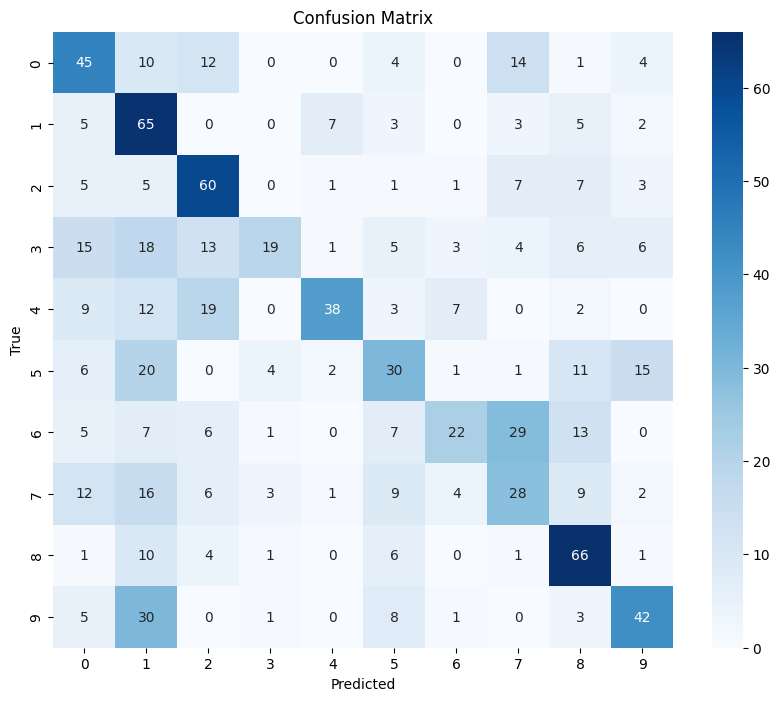

In [10]:
'''
' Confusion Matrix of Model Predictions on unseen test data.
'''
xy_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cm_ais = confusion_matrix(all_true_ais, all_preds_ais)

plt.figure(figsize = (10, 8))
sns.heatmap(cm_ais, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = xy_labels, yticklabels = xy_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()